tiny yolo 2 for single channel data trained on the provided data only 

git reposotories used: 

https://github.com/joycex99/tiny-yolo-keras/blob/master/Tiny%20Yolo%20Keras.ipynb

https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb

In [1]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np

import pickle, json, copy, cv2
from preprocessing import parse_lables, new_img_ann, split_data

from generator1 import DataGenerator


# import labels

global IMAGE_H, IMAGE_W, THRESHOLD #, SCALE_NOOB, SCALE_OBJECT, SCALE_COOR, SCALE_CLASS


%matplotlib inline

Using TensorFlow backend.


In [3]:
LABELS = ['1', '2']
# IMAGE_H, IMAGE_W = 416, 416
IMAGE_H, IMAGE_W =  480,640
GRID_H, GRID_W = 15 , 20
BOX              = 5
CLASS            = len(LABELS)

CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')

THRESHOLD = 0.3

ANCHORS          = [4.031250,2.000000, 4.718750,2.343750, 5.312500,2.656250, 6.406250,3.187500, 12.781250,6.375000]


SCALE_NOOB  = 1.0
SCALE_OBJECT     = 5.0
SCALE_COOR      = 1.0
SCALE_CLASS     = 1.0

BATCH_SIZE       = 64
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [4]:
# wt_path = 'yolo.weights'                      
img_dir = 'data/depth/'
labels = 'data/labels.txt'


In [5]:
# imgs, seen_labels = parse_lables (labels, img_dir)

# # split into training and validation 
# train_imgs, val_imgs = split_data (imgs, 0.2)
    
#  ## write parsed annotations to pickle for fast retrieval next time
# with open('train_imgs', 'wb') as fp:
#     pickle.dump(train_imgs, fp)
# # write parsed annotations to pickle for fast retrieval next time
# with open('val_imgs', 'wb') as fp:
#     pickle.dump(val_imgs, fp)

   

In [6]:
## read saved pickle of parsed annotations
with open ('val_imgs', 'rb') as fp:
    val_imgs = pickle.load(fp)

## read saved pickle of parsed annotations
with open ('train_imgs', 'rb') as fp:
    train_imgs = pickle.load(fp)

{'width': 640, 'object': [{'ymax': 529, 'box_height': 145, 'box_width': 290, 'xmax': 412, 'xmin': 122, 'ymin': 384, 'name': '1'}, {'ymax': 466, 'box_height': 207, 'box_width': 414, 'xmax': 480, 'xmin': 66, 'ymin': 259, 'name': '1'}], 'filename': 'data/depth/seq0_0000_1.pgm', 'height': 480}
(480, 640, 3)
(480, 640)


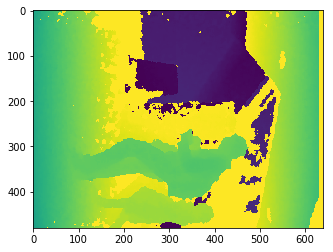

In [7]:
print train_imgs[1]

image = cv2.imread(train_imgs[1]['filename'])
print  image.shape

plt.imshow(image)

tmp= image[:,:,1]
plt.imshow(tmp)
print  tmp.shape


In [8]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 1))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

In [9]:
# Layer 1
x = Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=False)(input_image)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)


# Layer 2 - 5
for i in range(0,4):
    x = Conv2D((32*(2**i)), (3,3), strides=(1,1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
# Layer 6
x = Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

# # Layer 7 - 8
# for _ in range(0,2):
#     x = Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.1)(x)

# Layer 9
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
x = Activation('linear')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# output = Lambda(lambda args: args[0])([output, true_boxes])


In [10]:
model = Model([input_image, true_boxes], output)

In [13]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_H), [GRID_W]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,1,2,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * SCALE_COOR
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * SCALE_NOOB
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * SCALE_OBJECT
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * SCALE_CLASS       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < SCALE_COOR/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
#     loss = tf.Print(loss, [best_ious], message='IOU \t', summarize=1000)
    
    return loss

In [15]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [18]:
# Generators
train_gen = DataGenerator(train_imgs, generator_config)
val_gen = DataGenerator(val_imgs, generator_config)

In [19]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_anchors.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [20]:
if not os.path.exists('./logs'): os.makedirs('./logs')
    
tb_counter  = len([log for log in os.listdir(os.path.expanduser('./logs/')) if 'depth_' in log]) + 1


In [21]:
tensorboard = TensorBoard(log_dir=os.path.expanduser('.logs/') + 'depth_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

In [22]:
optimizer = Adam(lr=0.5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [23]:
model.compile(loss=custom_loss, optimizer=optimizer)

In [ ]:
model.fit_generator(generator        = train_gen, 
                    steps_per_epoch  = len(train_gen), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = val_gen,
                    validation_steps = len(val_gen),
                    callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)

Epoch 1/100
29/29 [==============================] - 1726s 60s/step - loss: 121.4733 - val_loss: 56.5619

Epoch 00001: val_loss improved from inf to 56.56188, saving model to weights_anchors.hdf5
Epoch 2/100
29/29 [==============================] - 1556s 54s/step - loss: 68.0990 - val_loss: 52.6937

Epoch 00002: val_loss improved from 56.56188 to 52.69367, saving model to weights_anchors.hdf5
Epoch 3/100
29/29 [==============================] - 1682s 58s/step - loss: 55.2165 - val_loss: 67.5023

Epoch 00003: val_loss did not improve from 52.69367
Epoch 4/100
 9/29 [========>.....................] - ETA: 18:56 - loss: 50.6932